# Tentative Results

## Configurations

- Test System: HP (2x Intel E5-2630 v2 @ 2.6GHz, 24 vCPUs, 64GB DDR3)
- SDD drive under test: 128GB - TOSHIBA THNSNJ128G8NU (S/N: 75AS1011T9HW)
- Filesystem: XFS
- RocksDB: 16B key size, 8KB value size
- RocksDB version: 5.14.3
- YCSB version: https://github.com/ljishen/YCSB @ d4168eb77c53e30b3792b9cff4bbb9be3818b510
- Maven version: 3.5.4
- Java version: 1.8.0_181, Oracle Corporation
- System info: Ubuntu 16.04.5 LTS, Linux pl2 4.4.132-0404132-generic #201805211041 SMP Mon May 21 10:42:56 UTC 2018 x86_64 x86_64 x86_64 GNU/Linux
- [RocksDB options file](https://github.com/ljishen/ycsb-rocksdb/blob/master/analysis/data/workloadc/workloadc_13/OPTIONS), data are all in the column family **usertable**

#### workloadc

- Total 13081649 keys. The database dir size is 100.76 GB.
- [YCSB workload parameter file](https://github.com/ljishen/ycsb-rocksdb/blob/master/analysis/data/workloadc/workloadc_21/myworkloadc), inherited from the [read only workloadc](https://github.com/ljishen/YCSB/wiki/Core-Workloads), read 75% (~75GB) of the data set size

#### FileSystem Information

```
$ xfs_info  /mnt/sda1
meta-data=/dev/sda1              isize=512    agcount=4, agsize=7812630 blks
         =                       sectsz=512   attr=2, projid32bit=1
         =                       crc=1        finobt=1 spinodes=0
data     =                       bsize=4096   blocks=31250518, imaxpct=25
         =                       sunit=0      swidth=0 blks
naming   =version 2              bsize=4096   ascii-ci=0 ftype=1
log      =internal               bsize=4096   blocks=15259, version=2
         =                       sectsz=512   sunit=0 blks, lazy-count=1
realtime =none                   extsz=4096   blocks=0, rtextents=0
```

Note that the sector size is 512 bytes.

## Distribution of Requested Block Sizes

```txt
SECTORS      COUNT      RATIO
---------------------------------------------
24      ->   13294511   71.557%
16      ->   4565344    24.573%
8       ->   571835     3.078%
32      ->   130837     0.704%
256     ->   15227      0.082%
240     ->   177        0.001%
248     ->   143        0.001%
0       ->   113        0.001%
232     ->   85         0.000%
128     ->   70         0.000%
224     ->   63         0.000%
208     ->   54         0.000%
104     ->   51         0.000%
216     ->   41         0.000%
136     ->   33         0.000%
144     ->   29         0.000%
200     ->   28         0.000%
1       ->   28         0.000%
160     ->   24         0.000%
2       ->   23         0.000%
176     ->   23         0.000%
120     ->   21         0.000%
40      ->   19         0.000%
168     ->   19         0.000%
112     ->   17         0.000%
64      ->   15         0.000%
152     ->   15         0.000%
88      ->   14         0.000%
192     ->   12         0.000%
48      ->   9          0.000%
17      ->   8          0.000%
15      ->   8          0.000%
184     ->   7          0.000%
56      ->   4          0.000%
5       ->   4          0.000%
13      ->   4          0.000%
12      ->   3          0.000%
18      ->   1          0.000%
14      ->   1          0.000%
10      ->   1          0.000%
```

## System Memory

Memory is almost filled up with page cache

```
$ free -mh
              total        used        free      shared  buff/cache   available
Mem:            62G        3.5G        1.6G         60M         57G         58G
Swap:          974M        967M        7.8M
```

## System CPU

~50% of iowait on average, which means the CPUs are far from saturated. 

Info of the max YCSB throughput: 21 threads -> {'device_iops': {'mean': 26942.213511605914, 'std': 167.14677325896}, 'device_throughput': {'mean': 287.09259635499245, 'std': 1.7925226780570087}, 'ycsb_throughput': {'mean': 67517.369925388659, 'std': 421.74540293876839}}


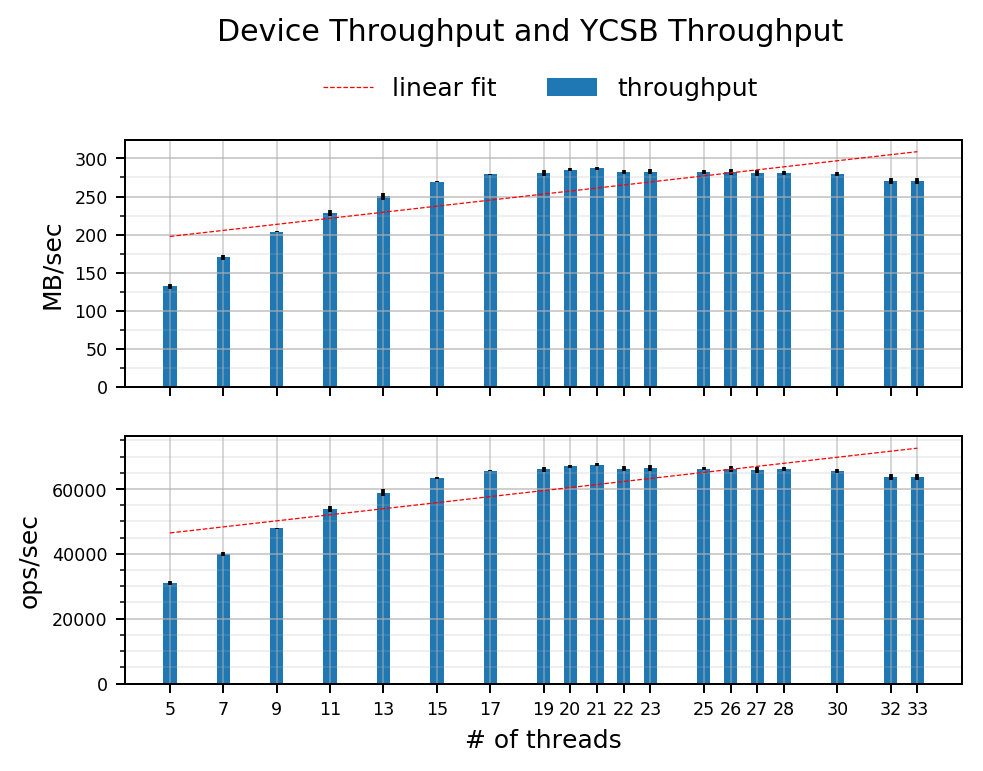

In [2]:
import glob
import re

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator


_SUFFIX = 'suf'
_VALUES = 'vals'

_BEFORE = 'before'
_AFTER = 'after'

SECTOR_SIZE_KB = 0.5


def __get_stats_diffs(file_prefix):
    stat2vals = {
        _BEFORE: {_SUFFIX: '_b.log', _VALUES: []},
        _AFTER:  {_SUFFIX: '_a.log', _VALUES: []}
    }

    for key, kv in stat2vals.items():
        with open(file_prefix + kv[_SUFFIX], 'r') as fh:
            content = fh.read()
            comps = content.split()
            for i in range(3, len(comps)):
                stat2vals[key][_VALUES].append(int(comps[i]))

    diffs = []
    for i in range(len(stat2vals[_BEFORE][_VALUES])):
        diffs.append(stat2vals[_AFTER][_VALUES][i] - stat2vals[_BEFORE][_VALUES][i])
    return diffs


def __get_runtime_sec_and_throughput(trans_file):
    with open(trans_file, 'r') as fh:
        runtime = 0
        throughput = 0
        for line in fh:
            if 'RunTime' in line:
                # the `Runtime` value is in ms
                runtime = int(re.split(', *', line)[2]) / 1000
            elif 'Throughput(ops/sec)' in line:
                throughput = float(re.split(', *', line)[2])
                break

    return runtime, throughput


def __get_stats(dir, round):
    device_stats_file_prefix = dir + '/device_stats_round' + str(round)
    transactions_file = dir + '/transactions_round' + str(round) + '.dat'

    runtime, ycsb_throughput = __get_runtime_sec_and_throughput(transactions_file)
    diffs = __get_stats_diffs(device_stats_file_prefix)

    # read IOPS, read MB/s, YCSB ops/sec
    return diffs[0] / runtime, \
            diffs[2] * SECTOR_SIZE_KB / 1024 / runtime, \
            ycsb_throughput


def __get_rounds_in_ss_window(dir):
    profiles = glob.glob(dir + '/transactions_round[0-9]*.dat')

    if len(profiles) < 5:
        raise RuntimeError(
            'Not enough transaction profiles in ' + dir)

    rounds = []
    for profile in profiles:
        rounds.append(int(re.search(r'round(\d+)', profile).group(1)))

    return sorted(rounds)[-5:]


from os.path import basename


def __get_threadcount(dir):
    return int(basename(dir).split('_')[1])


_DEVICE_IOPS = 'device_iops'
_DEVICE_THROUGHPUT = 'device_throughput'
_YCSB_THROUGHPUT = 'ycsb_throughput'

_MEAN = 'mean'
_STD = 'std'


def __get_avg_throughputs(dir):
    rounds = __get_rounds_in_ss_window(dir)

    device_iopses = []
    device_throughputs = []
    ycsb_throughputs = []

    for r in rounds:
        device_iops, device_throughput, ycsb_throughput = __get_stats(dir, r)
        device_iopses.append(device_iops)
        device_throughputs.append(device_throughput)
        ycsb_throughputs.append(ycsb_throughput)

    return __get_threadcount(dir), \
            {
                _DEVICE_IOPS:       {
                    _MEAN: np.mean(device_iopses),
                    _STD:  np.std(device_iopses, ddof=1)  
                },
                _DEVICE_THROUGHPUT: {
                    _MEAN: np.mean(device_throughputs),
                    _STD:  np.std(device_throughputs, ddof=1)
                },
                _YCSB_THROUGHPUT:   {
                    _MEAN: np.mean(ycsb_throughputs),
                    _STD:  np.std(ycsb_throughputs, ddof=1)
                }
            }


def __list_subfolders(folder):
    return glob.glob('../data/' + folder + '/' + folder + '_[0-9]*')


def plot_throughputs(folder):
    fig, axes = plt.subplots(2, 1, sharex='col')
    fig.set_dpi(180)

    dev_th_ax = axes[0]
    ycsb_th_ax = axes[1]

    tc2th = {}
    subfolders = __list_subfolders(folder)
    for subf in subfolders:
        threadcount, throughputs = __get_avg_throughputs(subf)
        tc2th[threadcount] = throughputs
        
    tcs = sorted(tc2th.keys())
    ths = []
    for tc in tcs:
        ths.append(tc2th[tc])

    max_key = max(tc2th.keys(), key=(lambda key: tc2th[key][_YCSB_THROUGHPUT][_MEAN]))
    print('Info of the max YCSB throughput: ' + str(max_key) + ' threads -> ' + str(tc2th[max_key]))

    width = 0.5
    lines = []

    means = [v[_DEVICE_THROUGHPUT][_MEAN] for v in ths]
    dev_th_ax.bar(tcs,
                  means, width,
                  yerr=[v[_DEVICE_THROUGHPUT][_STD] for v in ths],
                  label='throughput')
    lines.append(dev_th_ax.plot(tcs,
                                np.poly1d(np.polyfit(tcs, means, 1))(np.unique(tcs)),
                                label='linear fit'))

    means = [v[_YCSB_THROUGHPUT][_MEAN] for v in ths]
    ycsb_th_ax.bar(tcs,
                   means, width,
                   yerr=[v[_YCSB_THROUGHPUT][_STD] for v in ths])
    lines.append(ycsb_th_ax.plot(tcs,
                                 np.poly1d(np.polyfit(tcs, means, 1))(np.unique(tcs))))

    plt.setp(lines, linewidth=0.5, linestyle='--', color='r')

    dev_th_ax.set_ylabel('MB/sec')
    dev_th_ax.tick_params(labelsize=7)
    dev_th_ax.yaxis.set_minor_locator(MultipleLocator(25))
    dev_th_ax.grid(which='major', alpha=0.5)
    dev_th_ax.grid(which='minor', alpha=0.2)

    ycsb_th_ax.set_ylabel('ops/sec')
    ycsb_th_ax.tick_params(labelsize=7)
    ycsb_th_ax.yaxis.set_minor_locator(MultipleLocator(5000))
    ycsb_th_ax.grid(which='major', alpha=0.5)
    ycsb_th_ax.grid(which='minor', alpha=0.2)

    plt.xlabel('# of threads')
    plt.xticks(tcs)
    plt.suptitle('Device Throughput and YCSB Throughput', y=1.05)

    plt.figlegend(loc=8,
                  bbox_to_anchor=(0.5, 0.9),
                  frameon=False,
                  ncol=2)

    plt.show()


plot_throughputs('workloadc')

According to the [baseline IOPS performance](https://github.com/ljishen/SSSPT/blob/master/analysis/notebooks/conclusion.ipynb) of this drive, we use degree of 5 to generate the fitting polynomial:

In [3]:
x = [0.5, 4, 8, 16, 32, 64, 128, 1024]
_y = [38345.034, 37472.950, 34949.841, 21339.819, 11550.429, 6065.414, 3162.433, 416.407]
y = []
for idx, val in enumerate(x):
    y.append(val * _y[idx] / 1024)
    print(str(val) + ' KB\t->\t' + str(y[-1]) + ' MB/s')

z = np.polyfit(x, y, 5)
p = np.poly1d(z)

avg_throughput = p(12) * 0.71557 + p(8) * 0.24573 + p(4) * 0.03078 + p(16) * 0.00704

print('\nThe estimated theoretical throughput is %f MB/s' % avg_throughput)

0.5 KB	->	18.7231611328125 MB/s
4 KB	->	146.3787109375 MB/s
8 KB	->	273.0456328125 MB/s
16 KB	->	333.434671875 MB/s
32 KB	->	360.95090625 MB/s
64 KB	->	379.088375 MB/s
128 KB	->	395.304125 MB/s
1024 KB	->	416.407 MB/s

The estimated theoretical throughput is 293.916565 MB/s


The throughput in the test (287.09 MB/s) is close to the number we calculated above, meaning the test has reached the upper limit of theoretical throughput.

In [4]:
print('The average IO ratio (device_iops / ycsb_ops) is ' + str(26942.213511605914 / 67517.369925388659))
print('The average throughput ratio (device_mbs / ycsb_mbs) is ' + \
      str(287.09259635499245 / (67517.369925388659 * (8192 + 16) / 1024 / 1024)))

The average IO ratio (device_iops / ycsb_ops) is 0.3990412177100339
The average throughput ratio (device_mbs / ycsb_mbs) is 0.5432116081173293


#### workloada

- Total 9811237 keys. The database dir size is 75.57 GB. It then bumps to about 102.6 GB after finish running the workloada.
- [YCSB workload parameter file](https://github.com/ljishen/ycsb-rocksdb/blob/master/analysis/data/workloada/workloada_5/myworkloada), inherited from the [update heavy workloada](https://github.com/ljishen/YCSB/wiki/Core-Workloads). It has a mix of 50/50 reads and writes that operates on the same number as the number of keys.